In [5]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra
from PIL import Image
import cv2
import os
import torch
import torch.nn.functional as F
from torch import nn
import itertools
from torch.utils.tensorboard import SummaryWriter
import random
import gc
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import MeanShift, estimate_bandwidth, OPTICS


In [6]:
cebra_model_path = 'models/cebra_model_complete.pt'


In [7]:
data_directory = '/mnt/teams/Tsuchitori/MV1_run_30hz_30frame_brain2behav_DFF_new/'
neural_data_paths = [ data_directory + 'brain/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

behavior_data_paths = [  data_directory + 'camera1/' + \
                     file for file in os.listdir(data_directory + 'brain/')]

dino_paths = [ data_directory + 'dino/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

output_folder_paths = [ data_directory + 'output2/' + \
                        file for file in os.listdir(data_directory + 'brain/')]

In [8]:
hidden_units=128
output_dimension=16
model_name='offset1-model'
device='cuda:0'
input_size=128*128


In [9]:

def process_brain(brain_seq):
  brain_seq = np.array(brain_seq)
  flat_seq = np.array([(brain_frame.flatten()) for brain_frame in brain_seq])
  return flat_seq.astype(float)

## Loads data from a folder of TIF files
# filepath: path to folder
# processor: function to process each image
# max: max images to load as a proportion of array size
# min: min images to load as a proportion of array size
# returns: list of processed images, list of filenames
def import_data(filepath, processor, min = 0, max = 1):
    output_data = []
    output_name = []
    path_list = os.listdir(filepath)
    path_list.sort()
    random.Random(4).shuffle(path_list)
    min_index = int(min * len(path_list))
    max_index = int(max * len(path_list))
    for file in itertools.islice(path_list, min_index, max_index):
     filename = os.fsdecode(file)
     if filename.endswith(".tif"):
         out = cv2.imreadmulti(filepath + '/' + filename)[1]
         output_data.append(processor(out))
         output_name.append(filename.split('.')[0])
     elif filename.endswith(".npy"):
         output_data.append(processor(np.load(filepath + '/' + filename)))
         output_name.append(filename.split('.')[0])
     else:
         continue
    return output_data, output_name

def flatten_data(data):
    return np.concatenate(data, axis=0)

def generate_CEBRA_embeddings(neural, model, session):
    embedding = []
    failed = []
    for run, data in enumerate(neural):
        embedding_data = [model[session].forward(torch.from_numpy((frame)).float().to(device).unsqueeze(0)).detach().cpu().numpy().squeeze() for frame in data] 
        embedding.append(embedding_data)
    return embedding

def load_model(model_path, model_name, output_dimension, hidden_units, input_size, model_number):
    #find available device
    device = torch.device('cuda:0')
    saved_model = torch.load(model_path)
    model = torch.nn.ModuleList([
        cebra.models.init(model_name, input_size,
                            hidden_units, output_dimension, True)
        for _ in range(model_number)
    ]).to(device)
    model.__setstate__(saved_model)
    model.eval()
    return model

def reshape_frames(frames, shape_ref):
    shape_list = [np.shape(x)[0] for x in shape_ref]
    gen_video_list = []
    index = 0
    for shape in shape_list:
        gen_video_list.append((frames[index : index + shape]))
        index += shape
    return gen_video_list

#choose a random window of set size from the data deterministically based on seed
def choose_random_window( window_size, seed, data):
    random.seed(seed)
    start = random.randint(0, len(data) - window_size)
    return data[start:start+window_size]


In [10]:
model = load_model(cebra_model_path, model_name, output_dimension, hidden_units, input_size, 8)

In [11]:
def normalize_array(in_array):
    return np.array([x / np.linalg.norm(x) for x in in_array])

def match_frame_to_embeddings(predicted_embedding, embedding_train, image_train):
  cos_dist = np.matmul(embedding_train, predicted_embedding.T)
  index_list = np.argmax(cos_dist, axis=0)
  return image_train[index_list]

def predict_embeddings(neural_path, behavior_path,dino_path, validation_cutoff, model, session):
    # Load data
    print('Loading data')
    brain_data, name_data = import_data(neural_path, process_brain, max=validation_cutoff)
    behavior_data, _ = import_data(behavior_path, lambda x: x, max=validation_cutoff)
    dino_data, _ = import_data(dino_path, lambda x: x, max=validation_cutoff)
    # Generate embeddings
    print('Generating embeddings')
    embeddings = generate_CEBRA_embeddings(brain_data, model, session)

    print('Loading test data')
    # Load the test set of data
    brain_data_test, name_data_test = import_data(neural_path, process_brain, min = validation_cutoff, max=1)
    behavior_data_test, _ = import_data(behavior_path, lambda x: x, min = validation_cutoff, max=1)
    dino_data_test, _ = import_data(dino_path, lambda x: x, min = validation_cutoff, max=1)
    # Generate embeddings
    print('Generating test embeddings')
    embeddings_test = generate_CEBRA_embeddings(brain_data_test, model, session)

    # Flatten Data
    embeddings_flat = flatten_data(embeddings).squeeze()
    behavior_flat = flatten_data(behavior_data).squeeze()
    dino_flat = flatten_data(dino_data).squeeze()
    embedding_test_flat = flatten_data(embeddings_test).squeeze()
    dino_test_flat = flatten_data(dino_data_test).squeeze()

    print('Running KNN')
    # Create KNN decoder
    # print shapes of data
    print('embedding shape: ', np.shape(embeddings_flat))
    print('dino shape: ', np.shape(dino_flat))
    decoder = cebra.KNNDecoder(n_neighbors=20, metric="cosine")
    decoder.fit(embeddings_flat, dino_flat)

    # predict
    predicted_dino = decoder.predict(embedding_test_flat)

    # normalize predicted embeddings
    predicted_dino = normalize_array(predicted_dino)

    # Generate accuracy ratings by taking cosine distance to test dino set
    cos_dist =  np.matmul(predicted_dino, dino_test_flat.T)

    print('generating videos')
    # Match predicted embeddings to images
    predicted_images = match_frame_to_embeddings(predicted_dino, dino_flat, behavior_flat)
    reshaped_predicted_images = reshape_frames(predicted_images, brain_data_test)

    print('Running Clustering')
    #run Agglomerative clustering to predict class labels
    clustering = OPTICS(min_samples=0.1, metric='cosine').fit(embedding_test_flat)
    predicted_labels_flat = clustering.labels_

    #reshape predicted labels
    predicted_labels = reshape_frames(predicted_labels_flat, brain_data_test)
    cos_dist = reshape_frames(cos_dist, brain_data_test)

    return reshaped_predicted_images, name_data_test, predicted_labels, cos_dist, behavior_data_test


In [12]:
def display_frames_as_video(frames, ground_truth, frame_rate, name, labels, label_dict, accuracy, output_folder_path):
    fontScale = 0.5
    org = (50, 50)
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness = 1
    # Get the dimensions of the frames
    frame_height, frame_width = frames[0].shape
    # Classify video based on median label of all frames
    label = np.round(np.median(labels))
    label_class = label_dict[label]
    # Create a VideoWriter object to write the frames into a video file
    video_writer = cv2.VideoWriter(output_folder_path + '/'+ str(label) + '_' + name +'.mp4',
                                   cv2.VideoWriter_fourcc(*'mp4v'),
                                   frame_rate,
                                   (frame_width, 2 * frame_height))

    # Display frames
    for iter, frame in enumerate(zip(frames, ground_truth, labels, accuracy)):
        # Write the current frame to the video file
        color_frame = cv2.cvtColor(((frame[0]/2 + frames[iter - 1]/2)).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        color_truth = cv2.cvtColor(frame[1].astype(np.uint8), cv2.COLOR_GRAY2RGB)
        combined = np.concatenate((color_frame, color_truth))

        # write corresponding label to video corner
        combined  = cv2.putText(combined, str(frame[2]) + ' ' + str(frame[3]), org, font, 
                   fontScale, (0,0,255), thickness, cv2.LINE_AA)
        video_writer.write(combined)

    # Release the VideoWriter and close the window
    video_writer.release()
    cv2.destroyAllWindows()

In [13]:
label_classes = {0 : '0', 1 : '1', 2 : '2'}

In [14]:
for i, _ in enumerate(zip(neural_data_paths, behavior_data_paths, dino_paths)):
    pred_images, names, labels, accuracy, predict_behavior = predict_embeddings(neural_data_paths[i], behavior_data_paths[i], dino_paths[i], 0.8, model, i)
    for data in zip(labels, pred_images, names, predict_behavior):
        windowed_labels = choose_random_window(30, data[2], data[0])
        windowed_frames = choose_random_window(30, data[2], data[1])
        windowed_truth = choose_random_window(30, data[2], data[3])
        display_frames_as_video(windowed_frames, windowed_truth, 30, data[2], windowed_labels, label_classes, accuracy, output_folder_paths[i])

Loading data
Generating embeddings
Loading test data
Generating test embeddings
Running KNN
embedding shape:  (92084, 16)
dino shape:  (92084, 384)
generating videos
Running Clustering
Loading data


KeyboardInterrupt: 

Loading data
Generating embeddings
Running TSNE


/tmp/ipykernel_23611/269249482.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], cmap=colors)
/home/murph_4090ws/miniconda3/envs/cebra-env/lib/python3.11/site-packages/matplotlib/collections.py:1080: UserWarning: Collection without array used. Make sure to specify the values to be colormapped via the `c` argument.
  warnings.warn("Collection without array used. Make sure to "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


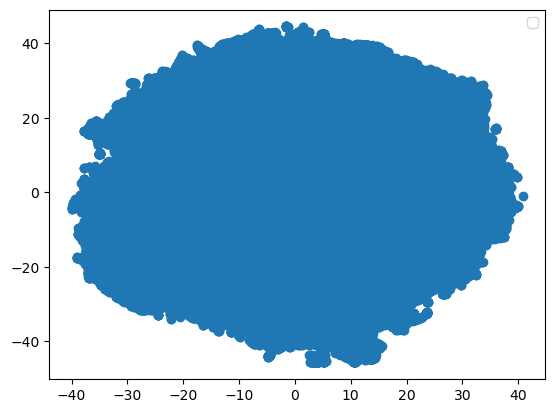

In [17]:
from matplotlib.colors import ListedColormap
from sklearn.manifold import TSNE

print('Loading data')
brain_data, name_data = import_data(neural_data_paths[0], process_brain, max=1)
print ('Generating embeddings')
embeddings = generate_CEBRA_embeddings(brain_data, model, 0)
embedding_flat = flatten_data(embeddings).squeeze()

# print('Running Clustering') 
# clustering = OPTICS(min_samples=0.1, metric='cosine').fit(embedding_flat)
# predicted_labels_flat = clustering.labels_

print('Running TSNE')
tsne_embedding = TSNE(n_components=2, n_iter=500, learning_rate='auto', metric='cosine',
                init='random', perplexity=30).fit_transform(embedding_flat)
colors = ListedColormap(['r','b','g'])
classes = ['still', 'running', 'sniffing']
#plot tsne plot as a scatterplot with labels
scatter = plt.scatter(tsne_embedding[:,0], tsne_embedding[:,1], cmap=colors)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.show()
